<a href="https://colab.research.google.com/github/jazielcarballo/PSEint/blob/master/hmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
pip install hmmlearn==0.3.3

  Using cached hmmlearn-0.3.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
Using cached hmmlearn-0.3.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (164 kB)
  Attempting uninstall: hmmlearn
    Found existing installation: hmmlearn 0.3.3.post1+ge01a10e
    Uninstalling hmmlearn-0.3.3.post1+ge01a10e:
      Successfully uninstalled hmmlearn-0.3.3.post1+ge01a10e


In [11]:
import numpy as np
import matplotlib.pyplot as plt



In [22]:

from hmmlearn import hmm

Model #0	Score: -26391.366333754417
Model #1	Score: -26395.55036935765
Model #2	Score: -26405.242643523045
Model #3	Score: -26396.290283735074
Model #4	Score: -26395.550365729432
Model #5	Score: -26375.751287787338
Model #6	Score: -26395.484471121286
Model #7	Score: -26300.674398143023
Model #8	Score: -26265.231791849812
Model #9	Score: -26395.55035772545
Model #10	Score: -26317.463400795976
Model #11	Score: -26405.406087293268
Model #12	Score: -26254.55767640742
Model #13	Score: -26395.48203896293
Model #14	Score: -26247.853013142605
Model #15	Score: -26280.57361146831
Model #16	Score: -26236.969346748076
Model #17	Score: -26320.85492611968
Model #18	Score: -26273.89241965143
Model #19	Score: -26404.09350827867
Model #20	Score: -26405.639243735335
Model #21	Score: -26385.763376940475
Model #22	Score: -26395.4853914974
Model #23	Score: -26395.550366095962
Model #24	Score: -26308.427880823318
Model #25	Score: -26395.506893588612
Model #26	Score: -26296.282415132187
Model #27	Score: -263

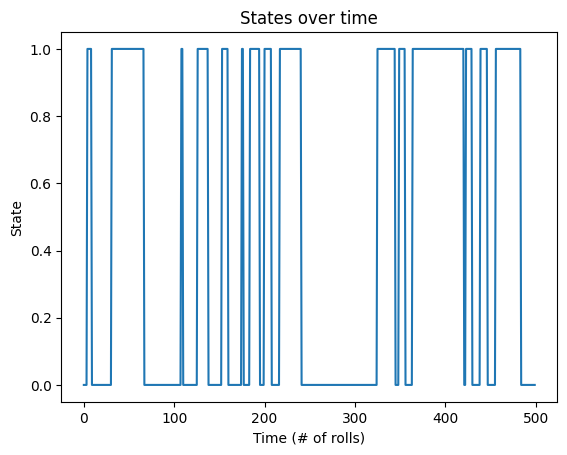

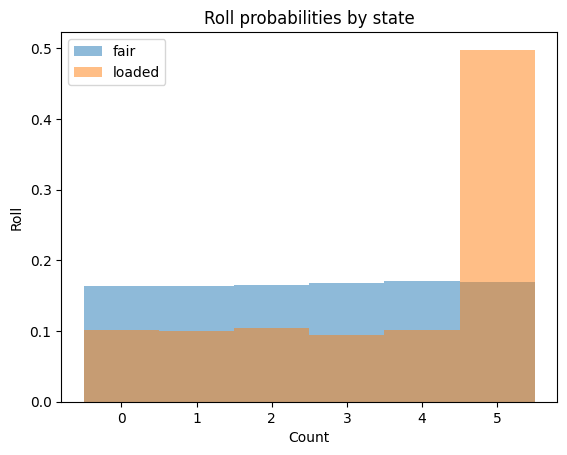

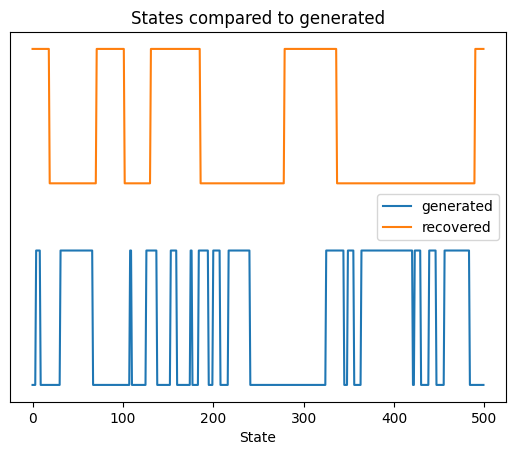

In [23]:
"""
Dishonest Casino Example
------------------------

We'll use the ubiquitous dishonest casino example to demonstrate
how to train a Hidden Markov Model (HMM) on somewhat realistic
test data (e.g. http://www.mcb111.org/w06/durbin_book.pdf
Chapter 3).

In this example, we suspect that a casino is trading out a fair
die (singular or dice) for a loaded die. We want to figure out
1) when the loaded die was used (i.e. the most likely path) 2) how
often the loaded die is used (i.e. the transition probabilities) and
3) the probabilities for each outcome of a roll for the loaded die
(i.e. the emission probabilities).
"""

# %%
# First, import necessary modules and functions.



# %%
# Now, let's act as the casino and exchange a fair die for a loaded one
# and generate a series of rolls that someone at the casino would
# observe.

# make our generative model with two components, a fair die and a
# loaded die
gen_model = hmm.CategoricalHMM(n_components=2, random_state=99)

# the first state is the fair die so let's start there so no one
# catches on right away
gen_model.startprob_ = np.array([1.0, 0.0])

# now let's say that we sneak the loaded die in:
# here, we have a 95% chance to continue using the fair die and a 5%
# chance to switch to the loaded die
# when we enter the loaded die state, we have a 90% chance of staying
# in that state and a 10% chance of leaving
gen_model.transmat_ = np.array([[0.95, 0.05],
                                [0.1, 0.9]])

# now let's set the emission means:
# the first state is a fair die with equal probabilities and the
# second is loaded by being biased toward rolling a six
gen_model.emissionprob_ = \
    np.array([[1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],
              [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 2]])

# simulate the loaded dice rolls
rolls, gen_states = gen_model.sample(30000)

# plot states over time, let's just look at the first rolls for clarity
fig, ax = plt.subplots()
ax.plot(gen_states[:500])
ax.set_title('States over time')
ax.set_xlabel('Time (# of rolls)')
ax.set_ylabel('State')
fig.show()

# plot rolls for the fair and loaded states
fig, ax = plt.subplots()
ax.hist(rolls[gen_states == 0], label='fair', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.hist(rolls[gen_states == 1], label='loaded', alpha=0.5,
        bins=np.arange(7) - 0.5, density=True)
ax.set_title('Roll probabilities by state')
ax.set_xlabel('Count')
ax.set_ylabel('Roll')
ax.legend()
fig.show()

# %%
# Now, let's see if we can recover our hidden states, transmission matrix
# and emission probabilities.

# split our data into training and validation sets (50/50 split)
X_train = rolls[:rolls.shape[0] // 2]
X_validate = rolls[rolls.shape[0] // 2:]

# check optimal score
gen_score = gen_model.score(X_validate)

best_score = best_model = None
n_fits = 50
np.random.seed(13)
for idx in range(n_fits):
    model = hmm.CategoricalHMM(
        n_components=2, random_state=idx,
        init_params='se')  # don't init transition, set it below
    # we need to initialize with random transition matrix probabilities
    # because the default is an even likelihood transition
    # we know transitions are rare (otherwise the casino would get caught!)
    # so let's have an Dirichlet random prior with an alpha value of
    # (0.1, 0.9) to enforce our assumption transitions happen roughly 10%
    # of the time
    model.transmat_ = np.array([np.random.dirichlet([0.9, 0.1]),
                                np.random.dirichlet([0.1, 0.9])])
    model.fit(X_train)
    score = model.score(X_validate)
    print(f'Model #{idx}\tScore: {score}')
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

print(f'Generated score: {gen_score}\nBest score:      {best_score}')

# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
states = best_model.predict(rolls)

# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(gen_states[:500], label='generated')
ax.plot(states[:500] + 1.5, label='recovered')
ax.set_yticks([])
ax.set_title('States compared to generated')
ax.set_xlabel('Time (# rolls)')
ax.set_xlabel('State')
ax.legend()
fig.show()

# %%
# Let's check our learned transition probabilities and see if they match.

print(f'Transmission Matrix Generated:\n{gen_model.transmat_.round(3)}\n\n'
      f'Transmission Matrix Recovered:\n{best_model.transmat_.round(3)}\n\n')

# %%
# Finally, let's see if we can tell how the die is loaded.

print(f'Emission Matrix Generated:\n{gen_model.emissionprob_.round(3)}\n\n'
      f'Emission Matrix Recovered:\n{best_model.emissionprob_.round(3)}\n\n')

# %%
# In this case, we were able to get very good estimates of the transition and
# emission matrices, but decoding the states was imperfect. That's because
# the decoding algorithm is greedy and picks the most likely series of states
# which isn't necessarily what happens in real life. Even so, our model could
# tell us when to watch for the loaded die and we'd have a better chance at
# catching them red-handed.